# 🎨 Flickr8k Text-to-Image Inference

This notebook loads a trained checkpoint and generates images from text prompts with different guidance scales.

## Features
- Load latest checkpoint automatically
- Generate images from custom text prompts
- Test multiple guidance scales (0 to 15)
- High-quality 256x256 image generation

## 1. Imports and Setup

In [1]:
from __future__ import annotations

import os
from dataclasses import dataclass
from typing import Optional

import numpy as np
import torch
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

from diffusers import DDPMScheduler
from diffusers.models import AutoencoderKL
from diffusers.models.unets.unet_2d_condition import UNet2DConditionModel

from transformers import CLIPTextModel, CLIPTokenizer

/home/doshlom4/work/conda/envs/torch114/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Configuration

In [2]:
@dataclass
class InferenceConfig:
    checkpoint_dir: str = "./outputs/train12_flickr8k_text2img"
    image_size: int = 256
    seed: int = 42
    # UNet size (must match training)
    unet_block_out_channels: tuple[int, ...] = (128, 256, 512, 512)
    layers_per_block: int = 2


config = InferenceConfig()

def get_device() -> torch.device:
    if torch.cuda.is_available():
        return torch.device("cuda")
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")

device = get_device()
print(f"Using device: {device}")

Using device: cuda


## 3. Load Models

In [3]:
print("Loading pretrained VAE...")
vae = AutoencoderKL.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="vae")
vae.requires_grad_(False)
vae.eval()
vae.to(device)

print("Loading CLIP text encoder...")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
text_encoder.requires_grad_(False)
text_encoder.eval()
text_encoder.to(device)

print("Creating UNet2DConditionModel...")
unet = UNet2DConditionModel(
    sample_size=config.image_size // 8,
    in_channels=4,
    out_channels=4,
    layers_per_block=config.layers_per_block,
    block_out_channels=config.unet_block_out_channels,
    down_block_types=(
        "DownBlock2D",
        "CrossAttnDownBlock2D",
        "CrossAttnDownBlock2D",
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",
        "CrossAttnUpBlock2D",
        "CrossAttnUpBlock2D",
        "UpBlock2D",
    ),
    cross_attention_dim=512,
).to(device)

num_params = sum(p.numel() for p in unet.parameters())
print(f"UNet parameters: {num_params:,}")

Loading pretrained VAE...
Loading CLIP text encoder...
Creating UNet2DConditionModel...
UNet parameters: 137,372,932


## 4. Load Latest Checkpoint

In [4]:
def find_latest_checkpoint(output_dir: str):
    """Find the latest checkpoint in the output directory."""
    if not os.path.exists(output_dir):
        return None
    
    checkpoint_files = []
    for filename in os.listdir(output_dir):
        if filename.endswith('.pt') and (filename.startswith('unet_step_') or 
                                         filename.startswith('unet_epoch_') or
                                         filename == 'unet_final.pt'):
            filepath = os.path.join(output_dir, filename)
            checkpoint_files.append(filepath)
    
    if not checkpoint_files:
        return None
    
    latest_checkpoint = max(checkpoint_files, key=os.path.getmtime)
    return latest_checkpoint


# Find and load checkpoint
checkpoint_path = find_latest_checkpoint(config.checkpoint_dir)

if checkpoint_path is None:
    raise FileNotFoundError(f"No checkpoint found in {config.checkpoint_dir}")

print(f"Loading checkpoint: {checkpoint_path}")
checkpoint = torch.load(checkpoint_path, map_location=device)

if isinstance(checkpoint, dict):
    if 'unet' in checkpoint:
        unet.load_state_dict(checkpoint['unet'])
        print(f"Loaded checkpoint from step {checkpoint.get('global_step', 'unknown')}, epoch {checkpoint.get('epoch', 'unknown')}")
    else:
        unet.load_state_dict(checkpoint)
else:
    unet.load_state_dict(checkpoint)

unet.eval()
print("✅ Checkpoint loaded successfully!")

Loading checkpoint: ./outputs/train12_flickr8k_text2img/unet_step_47000.pt
Loaded checkpoint from step 47000, epoch 24
✅ Checkpoint loaded successfully!


## 5. Text Encoding Helper

In [5]:
def encode_text(text: str, tokenizer, text_encoder, device):
    """Encode text prompt into embeddings using CLIP."""
    text_inputs = tokenizer(
        text,
        padding="max_length",
        max_length=tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    )
    text_input_ids = text_inputs.input_ids.to(device)
    
    with torch.no_grad():
        text_embeddings = text_encoder(text_input_ids)[0]
    
    return text_embeddings

## 6. Image Generation Function

In [6]:
@torch.no_grad()
def generate_image(
    prompt: str,
    num_inference_steps: int = 50,
    guidance_scale: float = 7.5,
    seed: Optional[int] = None,
):
    """Generate an image from a text prompt.
    
    Args:
        prompt: Text description of the image to generate
        num_inference_steps: Number of denoising steps (higher = better quality, slower)
        guidance_scale: Classifier-free guidance scale (higher = more prompt adherence)
        seed: Random seed for reproducibility
    
    Returns:
        Generated image tensor [1, 3, H, W] in range [0, 1]
    """
    if seed is not None:
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)

    # Create scheduler
    scheduler = DDPMScheduler(beta_schedule="squaredcos_cap_v2", num_train_timesteps=1000)
    scheduler.set_timesteps(num_inference_steps)

    # Encode text prompt
    text_embeddings = encode_text(prompt, tokenizer, text_encoder, device)
    
    # For classifier-free guidance, also encode empty prompt
    if guidance_scale > 1.0:
        uncond_embeddings = encode_text("", tokenizer, text_encoder, device)
        text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    # Initialize random latents
    latents = torch.randn((1, 4, config.image_size // 8, config.image_size // 8), device=device)

    # Denoising loop
    for t in tqdm(scheduler.timesteps, desc=f"Generating (guidance={guidance_scale})"):
        # Prepare latent input
        latent_model_input = latents
        if guidance_scale > 1.0:
            latent_model_input = torch.cat([latents] * 2)
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # Predict noise
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # Perform classifier-free guidance
        if guidance_scale > 1.0:
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # Step
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    # Decode latents to image
    latents = latents / 0.18215
    image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.cpu()

    return image

## 7. Generate Images with Different Guidance Scales

**Customize your prompt below!**

In [7]:
# ============================================================================
# CUSTOMIZE YOUR PROMPT HERE
# ============================================================================
prompt = "A dog"

# Different guidance scales to test
guidance_scales = [0, 3, 5, 7.5, 10, 15]

# Number of denoising steps (higher = better quality but slower)
num_inference_steps = 50

# Random seed for reproducibility
seed = 42
# ============================================================================

print(f"Prompt: '{prompt}'")
print(f"Guidance scales: {guidance_scales}")
print(f"Inference steps: {num_inference_steps}")
print(f"Seed: {seed}")
print("\n" + "="*80)

# Generate images
generated_images = []
for gs in guidance_scales:
    print(f"\nGenerating with guidance scale {gs}...")
    image = generate_image(
        prompt=prompt,
        guidance_scale=gs,
        num_inference_steps=num_inference_steps,
        seed=seed,
    )
    generated_images.append(image)

print("\n" + "="*80)
print("✅ All images generated!")

Prompt: 'A dog'
Guidance scales: [0, 3, 5, 7.5, 10, 15]
Inference steps: 50
Seed: 42


Generating with guidance scale 0...


Generating (guidance=0): 100%|██████████| 50/50 [00:01<00:00, 26.88it/s]



Generating with guidance scale 3...


Generating (guidance=3): 100%|██████████| 50/50 [00:01<00:00, 39.73it/s]



Generating with guidance scale 5...


Generating (guidance=5): 100%|██████████| 50/50 [00:01<00:00, 40.84it/s]



Generating with guidance scale 7.5...


Generating (guidance=7.5): 100%|██████████| 50/50 [00:01<00:00, 40.88it/s]



Generating with guidance scale 10...


Generating (guidance=10): 100%|██████████| 50/50 [00:01<00:00, 40.89it/s]



Generating with guidance scale 15...


Generating (guidance=15): 100%|██████████| 50/50 [00:01<00:00, 40.74it/s]


✅ All images generated!


## 8. Display Results

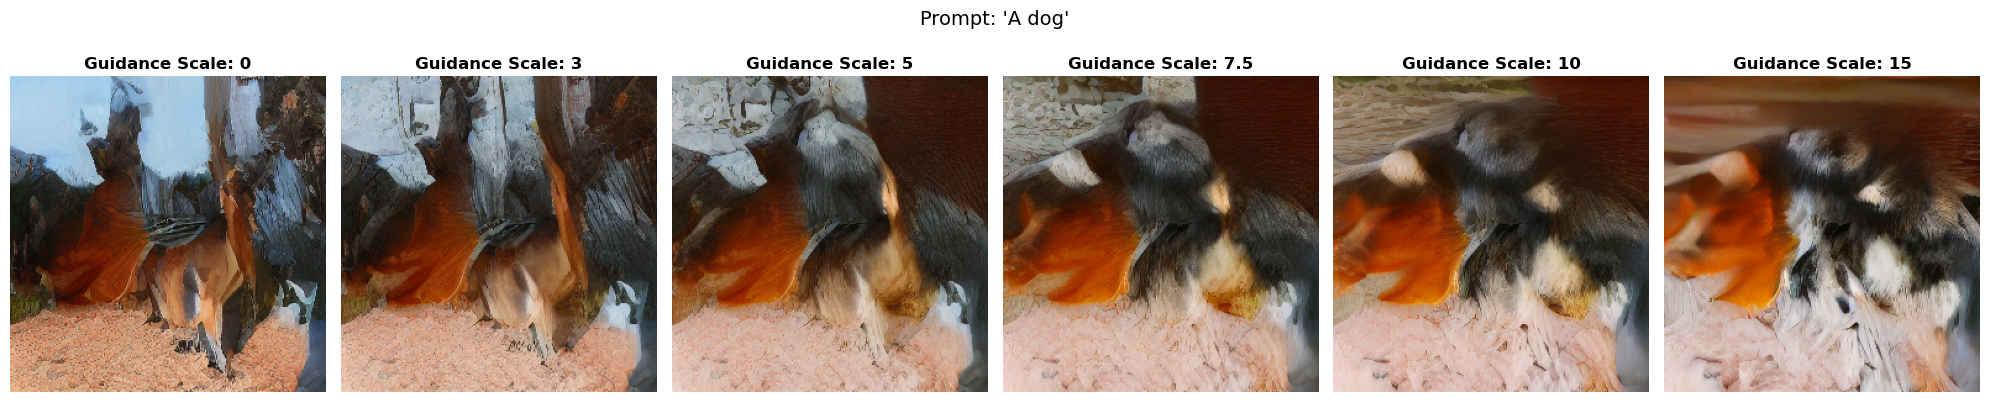

In [8]:
# Display all images in a row
fig, axes = plt.subplots(1, len(guidance_scales), figsize=(20, 4))

for ax, image, gs in zip(axes, generated_images, guidance_scales):
    img = image[0].permute(1, 2, 0).numpy()
    ax.imshow(img)
    ax.set_title(f"Guidance Scale: {gs}", fontsize=12, fontweight='bold')
    ax.axis('off')

plt.suptitle(f"Prompt: '{prompt}'", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 9. Save Images

In [9]:
from torchvision.utils import save_image

# Create output directory
output_dir = "./inference_outputs"
os.makedirs(output_dir, exist_ok=True)

# Save individual images
for i, (image, gs) in enumerate(zip(generated_images, guidance_scales)):
    filename = f"guidance_{gs}.png"
    filepath = os.path.join(output_dir, filename)
    save_image(image, filepath)
    print(f"Saved: {filepath}")

# Save comparison grid
grid_path = os.path.join(output_dir, "comparison_grid.png")
fig.savefig(grid_path, dpi=150, bbox_inches='tight')
print(f"\nSaved comparison grid: {grid_path}")

print(f"\n✅ All images saved to {output_dir}")

Saved: ./inference_outputs/guidance_0.png
Saved: ./inference_outputs/guidance_3.png
Saved: ./inference_outputs/guidance_5.png
Saved: ./inference_outputs/guidance_7.5.png
Saved: ./inference_outputs/guidance_10.png
Saved: ./inference_outputs/guidance_15.png

Saved comparison grid: ./inference_outputs/comparison_grid.png

✅ All images saved to ./inference_outputs


## 10. Generate Another Image (Optional)

Run this cell to quickly generate another image with a different prompt or settings.

Generating: 'A cat sitting on a windowsill watching birds'


Generating (guidance=7.5): 100%|██████████| 50/50 [00:01<00:00, 39.65it/s]


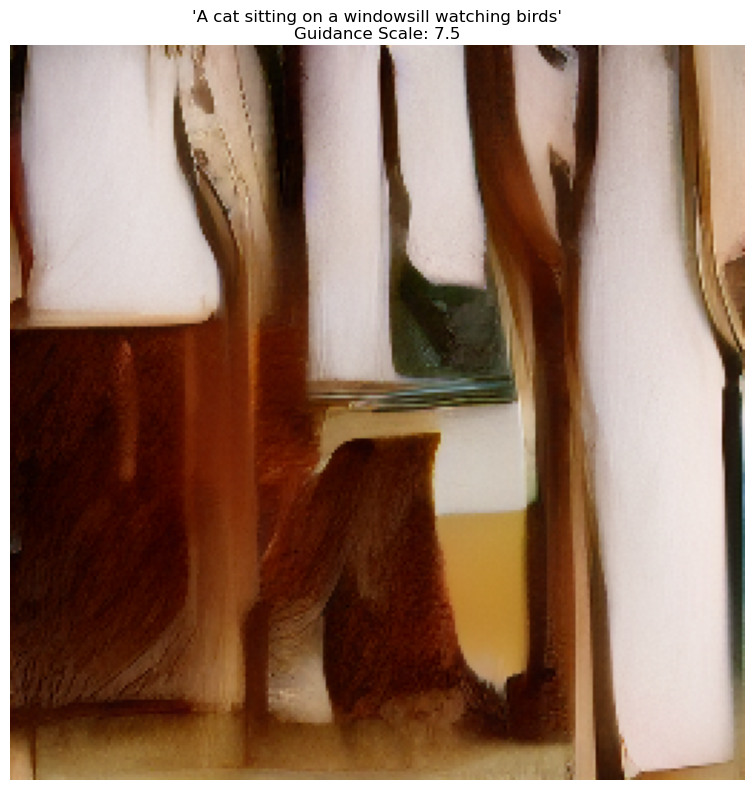

Saved: ./inference_outputs/custom_generation.png


In [10]:
# Quick generation with custom settings
custom_prompt = "A cat sitting on a windowsill watching birds"
custom_guidance = 7.5

print(f"Generating: '{custom_prompt}'")
image = generate_image(
    prompt=custom_prompt,
    guidance_scale=custom_guidance,
    num_inference_steps=50,
    seed=42,
)

# Display
plt.figure(figsize=(8, 8))
img = image[0].permute(1, 2, 0).numpy()
plt.imshow(img)
plt.title(f"'{custom_prompt}'\nGuidance Scale: {custom_guidance}", fontsize=12, wrap=True)
plt.axis('off')
plt.tight_layout()
plt.show()

# Save
save_path = os.path.join(output_dir, "custom_generation.png")
save_image(image, save_path)
print(f"Saved: {save_path}")

## Notes on Guidance Scale

- **0**: No guidance (unconditional generation, ignores prompt)
- **1-3**: Weak guidance (more creative, less adherence to prompt)
- **5-7.5**: Moderate guidance (balanced between creativity and prompt adherence) ✅ **Recommended**
- **10-15**: Strong guidance (strict adherence to prompt, may reduce diversity)
- **>15**: Very strong guidance (may produce artifacts or overfitting)

The optimal guidance scale depends on your specific use case and the complexity of the prompt.